##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Basic text classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates text classification starting from plain text files stored on disk. You'll train a binary classifier to perform sentiment analysis on an IMDB dataset. At the end of the notebook, there is an exercise for you to try, in which you'll train a multi-class classifier to predict the tag for a programming question on Stack Overflow.


In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


2025-02-24 22:24:41.376717: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740464681.391426   11843 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740464681.395398   11843 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-24 22:24:41.410298: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print(tf.__version__)

2.18.0


## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews.


### Download and explore the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.

In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb_v1/aclImdb')
# print(dataset_dir)

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


       0/84125825 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

    8192/84125825 ━━━━━━━━━━━━━━━━━━━━ 9:30 7us/step

   24576/84125825 ━━━━━━━━━━━━━━━━━━━━ 6:20 5us/step

   40960/84125825 ━━━━━━━━━━━━━━━━━━━━ 5:43 4us/step

   73728/84125825 ━━━━━━━━━━━━━━━━━━━━ 4:14 3us/step

  106496/84125825 ━━━━━━━━━━━━━━━━━━━━ 3:40 3us/step

  139264/84125825 ━━━━━━━━━━━━━━━━━━━━ 3:21 2us/step

  172032/84125825 ━━━━━━━━━━━━━━━━━━━━ 3:10 2us/step

  221184/84125825 ━━━━━━━━━━━━━━━━━━━━ 2:49 2us/step

  270336/84125825 ━━━━━━━━━━━━━━━━━━━━ 2:35 2us/step

  319488/84125825 ━━━━━━━━━━━━━━━━━━━━ 2:26 2us/step

  385024/84125825 ━━━━━━━━━━━━━━━━━━━━ 2:13 2us/step

  450560/84125825 ━━━━━━━━━━━━━━━━━━━━ 2:04 1us/step

  516096/84125825 ━━━━━━━━━━━━━━━━━━━━ 1:57 1us/step

  598016/84125825 ━━━━━━━━━━━━━━━━━━━━ 1:49 1us/step

  696320/84125825 ━━━━━━━━━━━━━━━━━━━━ 1:40 1us/step

  794624/84125825 ━━━━━━━━━━━━━━━━━━━━ 1:33 1us/step

  909312/84125825 ━━━━━━━━━━━━━━━━━━━━ 1:26 1us/step

 1040384/84125825 ━━━━━━━━━━━━━━━━━━━━ 1:20 1us/step

 1187840/84125825 ━━━━━━━━━━━━━━━━━━━━ 1:14 1us/step

 1351680/84125825 ━━━━━━━━━━━━━━━━━━━━ 1:08 1us/step

 1515520/84125825 ━━━━━━━━━━━━━━━━━━━━ 1:03 1us/step

 1712128/84125825 ━━━━━━━━━━━━━━━━━━━━ 59s 1us/step 

 1892352/84125825 ━━━━━━━━━━━━━━━━━━━━ 55s 1us/step

 2105344/84125825 ━━━━━━━━━━━━━━━━━━━━ 52s 1us/step

 2301952/84125825 ━━━━━━━━━━━━━━━━━━━━ 49s 1us/step

 2514944/84125825 ━━━━━━━━━━━━━━━━━━━━ 47s 1us/step

 2744320/84125825 ━━━━━━━━━━━━━━━━━━━━ 44s 1us/step

 2990080/84125825 ━━━━━━━━━━━━━━━━━━━━ 42s 1us/step

 3235840/84125825 ━━━━━━━━━━━━━━━━━━━━ 40s 1us/step

 3481600/84125825 ━━━━━━━━━━━━━━━━━━━━ 38s 0us/step

 3760128/84125825 ━━━━━━━━━━━━━━━━━━━━ 37s 0us/step

 4022272/84125825 ━━━━━━━━━━━━━━━━━━━━ 35s 0us/step

 4317184/84125825 ━━━━━━━━━━━━━━━━━━━━ 34s 0us/step

 4628480/84125825 ━━━━━━━━━━━━━━━━━━━━ 32s 0us/step

 4972544/84125825 ━━━━━━━━━━━━━━━━━━━━ 31s 0us/step

 5332992/84125825 ━━━━━━━━━━━━━━━━━━━━ 29s 0us/step

 5693440/84125825 ━━━━━━━━━━━━━━━━━━━━ 28s 0us/step

 6086656/84125825 ━━━━━━━━━━━━━━━━━━━━ 27s 0us/step

 6496256/84125825 ━━━━━━━━━━━━━━━━━━━━ 26s 0us/step

 6922240/84125825 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step

 7348224/84125825 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step

 7806976/84125825 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step

 8298496/84125825 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step

 8790016/84125825 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step

 9297920/84125825 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step

 9838592/84125825 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step

10412032/84125825 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step

11018240/84125825 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step

11657216/84125825 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step

12328960/84125825 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step

13049856/84125825 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step

13819904/84125825 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step

14655488/84125825 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step

15540224/84125825 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step

16490496/84125825 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step

17473536/84125825 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step

18522112/84125825 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step

19619840/84125825 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step

20766720/84125825 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step

21979136/84125825 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step 

23273472/84125825 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

24616960/84125825 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step

26025984/84125825 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

27516928/84125825 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

29057024/84125825 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

30679040/84125825 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

32382976/84125825 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

34168832/84125825 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

36036608/84125825 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

37953536/84125825 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

39985152/84125825 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

42065920/84125825 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step

44244992/84125825 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

46505984/84125825 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

48848896/84125825 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

51306496/84125825 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

53862400/84125825 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

56516608/84125825 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

59236352/84125825 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

62054400/84125825 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

64954368/84125825 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

67903488/84125825 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

70770688/84125825 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

73703424/84125825 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

76636160/84125825 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

79683584/84125825 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

82747392/84125825 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [10]:
os.listdir(dataset_dir)

['imdbEr.txt', 'imdb.vocab', 'test', 'train', 'README']

In [11]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'unsupBow.feat',
 'urls_pos.txt',
 'pos',
 'urls_neg.txt',
 'urls_unsup.txt',
 'unsup']

The `aclImdb/train/pos` and `aclImdb/train/neg` directories contain many text files, each of which is a single movie review. Let's take a look at one of them.

In [12]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### Load the dataset

Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) utility, which expects a directory structure as follows.

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

To prepare a dataset for binary classification, you will need two folders on disk, corresponding to `class_a` and `class_b`. These will be the positive and negative movie reviews, which can be found in  `aclImdb/train/pos` and `aclImdb/train/neg`. As the IMDB dataset contains additional folders, you will remove them before using this utility.

In [13]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. [tf.data](https://www.tensorflow.org/guide/data) is a powerful collection of tools for working with data.

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: [train](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set).

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

In [15]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


I0000 00:00:1740465646.921572   11843 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9557 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9


I0000 00:00:1725067500.786030   10188 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725067500.789584   10188 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725067500.793317   10188 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725067500.796882   10188 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

As you can see above, there are 25,000 examples in the training folder, of which you will use 80% (or 20,000) for training. As you will see in a moment, you can train a model by passing a dataset directly to `model.fit`. If you're new to `tf.data`, you can also iterate over the dataset and print out a few examples as follows.

In [17]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b"Having seen most of Ringo Lam's films, I can say that this is his best film to date, and the most unusual. It's a ancient china period piece cranked full of kick-ass martial arts, where the location of an underground lair full of traps and dungeons plays as big a part as any of the characters. The action is fantastic, the story is tense and entertaining, and the set design is truely memorable. Sadly, Burning Paradise has not been made available on DVD and vhs is next-to-impossible to get your mitts on, even if you near the second biggest china-town in North America (like I do). If you can find it, don't pass it up."
Label 1
Review b'Caution: May contain spoilers...<br /><br />I\'ve seen this movie 3 times & I\'ve liked it every time. Upon seeing it again, I\'m always reminded of how good it is. An HBO TV movie- very well done like most of their movies are- this would\'ve gotten Oscars for it\'s performances had it been released for general distribution instead of made for TV.<

2025-02-24 22:41:31.536563: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Notice the reviews contain raw text (with punctuation and occasional HTML tags like `<br/>`). You will show how to handle these in the following section.

The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, you can check the `class_names` property on the dataset.


In [18]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Next, you will create a validation and test dataset. You will use the remaining 5,000 reviews from the training set for validation.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [19]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


Using 5000 files for validation.


In [20]:
test_dir = os.path.join(dataset_dir, 'test')
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


### Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the helpful `tf.keras.layers.TextVectorization` layer.

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like `<br />`. These tags will not be removed by the default standardizer in the `TextVectorization` layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

Note: To prevent [training-testing skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew) (also known as training-serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the `TextVectorization` layer can be included directly inside your model, as shown later in this tutorial.

In [21]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, you will create a `TextVectorization` layer. You will use this layer to standardize, tokenize, and vectorize our data. You set the `output_mode` to `int` to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum `sequence_length`, which will cause the layer to pad or truncate sequences to exactly `sequence_length` values.

In [22]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Next, you will call `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: It's important to only use your training data when calling adapt (using the test set would leak information).

In [23]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [24]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [25]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

In [26]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [27]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training.

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [28]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

It's time to create your neural network:

In [29]:
embedding_dim = 16

In [30]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.  To learn more about embeddings, check out the [Word embeddings](https://www.tensorflow.org/text/guide/word_embeddings) tutorial.
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. The last layer is densely connected with a single output node.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use `losses.BinaryCrossentropy` loss function.

Now, configure the model to use an optimizer and a loss function:

In [31]:
model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

### Train the model

You will train the model by passing the `dataset` object to the fit method.

In [32]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10


I0000 00:00:1740465974.014793   18711 service.cc:148] XLA service 0xaa97900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740465974.014842   18711 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-02-24 22:46:14.050088: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740465974.148087   18711 cuda_dnn.cc:529] Loaded cuDNN version 90300


 23/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.5156 - loss: 0.6931  

I0000 00:00:1740465975.233337   18711 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - binary_accuracy: 0.5898 - loss: 0.6810 - val_binary_accuracy: 0.7186 - val_loss: 0.6141
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - binary_accuracy: 0.7572 - loss: 0.5809 - val_binary_accuracy: 0.8112 - val_loss: 0.4978
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.8178 - loss: 0.4697 - val_binary_accuracy: 0.8384 - val_loss: 0.4233
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.8489 - loss: 0.3976 - val_binary_accuracy: 0.8466 - val_loss: 0.3824
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.8673 - loss: 0.3505 - val_binary_accuracy: 0.8560 - val_loss: 0.3554
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.8772 - loss: 0.3176 - val_binary_accuracy: 0.8562 - val_loss: 0.3408
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.8890 - loss: 0.2929 - val_binary_accuracy: 0.8590 - val_loss: 0.3288
Epoch 8/10
625/62

 89/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.5286 - loss: 0.6921

I0000 00:00:1725067513.261163   10397 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


120/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.5302 - loss: 0.6917

151/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.5350 - loss: 0.6911

185/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.5403 - loss: 0.6905

218/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.5444 - loss: 0.6900

249/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.5480 - loss: 0.6895

281/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.5519 - loss: 0.6888

314/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.5558 - loss: 0.6881

346/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.5596 - loss: 0.6875

378/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.5631 - loss: 0.6868

411/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.5668 - loss: 0.6860

444/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.5703 - loss: 0.6852

476/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.5736 - loss: 0.6843

507/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.5767 - loss: 0.6835

539/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.5798 - loss: 0.6826

571/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.5828 - loss: 0.6817

604/625 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.5859 - loss: 0.6807

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - binary_accuracy: 0.5878 - loss: 0.6801 - val_binary_accuracy: 0.7314 - val_loss: 0.6106


Epoch 2/10


  1/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.8125 - loss: 0.5744

 41/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7451 - loss: 0.6071

 85/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7439 - loss: 0.6047

130/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7446 - loss: 0.6023

175/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7457 - loss: 0.6000

219/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7465 - loss: 0.5979

263/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7474 - loss: 0.5957

309/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7487 - loss: 0.5934

356/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7500 - loss: 0.5911

403/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7514 - loss: 0.5888

450/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7531 - loss: 0.5863

498/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7547 - loss: 0.5838

546/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7564 - loss: 0.5813

594/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7581 - loss: 0.5789

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.7592 - loss: 0.5773 - val_binary_accuracy: 0.8110 - val_loss: 0.4969


Epoch 3/10


  1/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - binary_accuracy: 0.8125 - loss: 0.4694

 45/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8116 - loss: 0.4817

 91/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8118 - loss: 0.4811

138/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8134 - loss: 0.4797

185/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8149 - loss: 0.4784

232/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8159 - loss: 0.4771

280/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8170 - loss: 0.4756

327/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8179 - loss: 0.4743

375/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8187 - loss: 0.4730

423/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8196 - loss: 0.4715

472/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8204 - loss: 0.4699

519/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8213 - loss: 0.4683

567/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8222 - loss: 0.4666

615/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8231 - loss: 0.4651

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.8232 - loss: 0.4648 - val_binary_accuracy: 0.8266 - val_loss: 0.4301


Epoch 4/10


  1/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - binary_accuracy: 0.8438 - loss: 0.3778

 44/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8455 - loss: 0.3991

 88/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8444 - loss: 0.4002

133/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8436 - loss: 0.4003

178/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8439 - loss: 0.4000

224/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8443 - loss: 0.3997

270/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8448 - loss: 0.3991

316/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8453 - loss: 0.3985

362/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8458 - loss: 0.3980

408/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8464 - loss: 0.3973

454/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8471 - loss: 0.3964

500/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8478 - loss: 0.3955

546/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8485 - loss: 0.3945

593/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8492 - loss: 0.3935

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.8496 - loss: 0.3929 - val_binary_accuracy: 0.8392 - val_loss: 0.3867


Epoch 5/10


  1/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - binary_accuracy: 0.9375 - loss: 0.3294

 45/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8836 - loss: 0.3412

 91/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8763 - loss: 0.3457

139/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8726 - loss: 0.3482

186/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8713 - loss: 0.3492

234/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8703 - loss: 0.3496

282/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8697 - loss: 0.3496

328/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8692 - loss: 0.3496

374/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8688 - loss: 0.3495

420/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8687 - loss: 0.3492

467/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8687 - loss: 0.3487

515/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8689 - loss: 0.3481

563/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8691 - loss: 0.3475

610/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8692 - loss: 0.3469

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.8693 - loss: 0.3467 - val_binary_accuracy: 0.8446 - val_loss: 0.3628


Epoch 6/10


  1/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - binary_accuracy: 0.9375 - loss: 0.3056

 46/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8899 - loss: 0.3093

 90/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8859 - loss: 0.3131

133/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8838 - loss: 0.3150

178/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8827 - loss: 0.3157

218/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8819 - loss: 0.3160

258/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8812 - loss: 0.3163

299/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8809 - loss: 0.3164

341/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8806 - loss: 0.3165

385/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8805 - loss: 0.3165

428/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8806 - loss: 0.3162

472/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8808 - loss: 0.3158

516/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8810 - loss: 0.3153

557/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8812 - loss: 0.3148

600/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8813 - loss: 0.3144

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.8814 - loss: 0.3142 - val_binary_accuracy: 0.8536 - val_loss: 0.3428


Epoch 7/10


  1/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - binary_accuracy: 0.9375 - loss: 0.2658

 44/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9072 - loss: 0.2827

 85/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9016 - loss: 0.2863

128/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8981 - loss: 0.2890

171/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8963 - loss: 0.2897

214/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8951 - loss: 0.2900

258/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8941 - loss: 0.2902

301/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8936 - loss: 0.2903

344/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8932 - loss: 0.2905

388/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8929 - loss: 0.2905

431/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8928 - loss: 0.2903

474/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8928 - loss: 0.2900

518/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8928 - loss: 0.2897

560/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8929 - loss: 0.2893

603/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8930 - loss: 0.2890

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.8930 - loss: 0.2889 - val_binary_accuracy: 0.8546 - val_loss: 0.3319


Epoch 8/10


  1/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - binary_accuracy: 0.8750 - loss: 0.2641

 43/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9037 - loss: 0.2599

 86/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9040 - loss: 0.2636

130/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9027 - loss: 0.2668

173/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9017 - loss: 0.2679

217/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9007 - loss: 0.2685

261/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8999 - loss: 0.2691

304/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8995 - loss: 0.2695

347/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8991 - loss: 0.2697

390/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8989 - loss: 0.2698

434/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8988 - loss: 0.2697

479/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8987 - loss: 0.2696

524/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8986 - loss: 0.2693

566/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8987 - loss: 0.2691

607/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.8986 - loss: 0.2689

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.8986 - loss: 0.2689 - val_binary_accuracy: 0.8568 - val_loss: 0.3250


Epoch 9/10


  1/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - binary_accuracy: 0.9688 - loss: 0.2232

 44/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9208 - loss: 0.2402

 88/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9168 - loss: 0.2453

130/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9135 - loss: 0.2491

173/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9116 - loss: 0.2505

216/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9104 - loss: 0.2511

255/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9097 - loss: 0.2516

296/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9091 - loss: 0.2520

339/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9086 - loss: 0.2524

383/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9082 - loss: 0.2525

426/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9080 - loss: 0.2524

469/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9079 - loss: 0.2522

511/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9079 - loss: 0.2520

552/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9079 - loss: 0.2518

595/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9079 - loss: 0.2516

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.9079 - loss: 0.2515 - val_binary_accuracy: 0.8570 - val_loss: 0.3201


Epoch 10/10


  1/625 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - binary_accuracy: 0.9062 - loss: 0.2121

 42/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9166 - loss: 0.2286

 85/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9154 - loss: 0.2328

129/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9138 - loss: 0.2366

173/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9130 - loss: 0.2377

217/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9126 - loss: 0.2379

261/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9123 - loss: 0.2384

306/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9121 - loss: 0.2387

350/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9119 - loss: 0.2389

396/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9117 - loss: 0.2389

440/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9117 - loss: 0.2388

485/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9117 - loss: 0.2385

528/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9118 - loss: 0.2382

573/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9118 - loss: 0.2380

617/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.9118 - loss: 0.2379

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.9118 - loss: 0.2379 - val_binary_accuracy: 0.8592 - val_loss: 0.3156


### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [33]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.8574 - loss: 0.3318
Loss:  0.3301909267902374
Accuracy:  0.8571199774742126


 30/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8708 - loss: 0.3455  

 59/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8619 - loss: 0.3496

 89/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8580 - loss: 0.3502

121/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8569 - loss: 0.3472

154/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8561 - loss: 0.3452

186/782 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8555 - loss: 0.3441

217/782 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8554 - loss: 0.3431

245/782 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8554 - loss: 0.3423

271/782 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8554 - loss: 0.3416

301/782 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8553 - loss: 0.3411

333/782 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8551 - loss: 0.3408

364/782 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8550 - loss: 0.3405

395/782 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8548 - loss: 0.3402

422/782 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8546 - loss: 0.3400

452/782 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8544 - loss: 0.3399

480/782 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8542 - loss: 0.3397

511/782 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8541 - loss: 0.3394

543/782 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8540 - loss: 0.3392

574/782 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8538 - loss: 0.3391

606/782 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8537 - loss: 0.3389

638/782 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8536 - loss: 0.3388

670/782 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8536 - loss: 0.3387

704/782 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8535 - loss: 0.3385

736/782 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8535 - loss: 0.3384

769/782 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.8534 - loss: 0.3383

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8534 - loss: 0.3383


Loss:  0.33511972427368164
Accuracy:  0.8527200222015381


This fairly naive approach achieves an accuracy of about 86%.

### Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [34]:
history_dict = history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

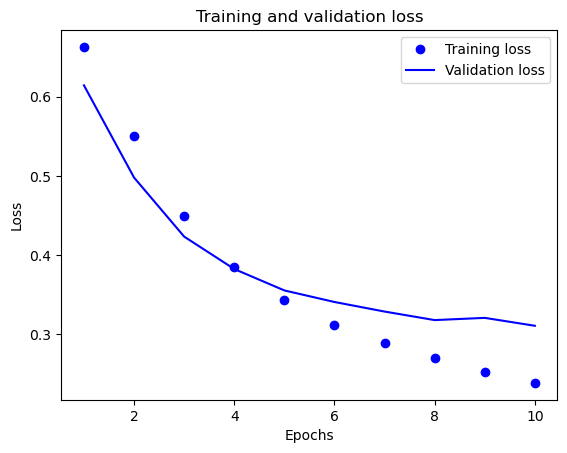

In [35]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

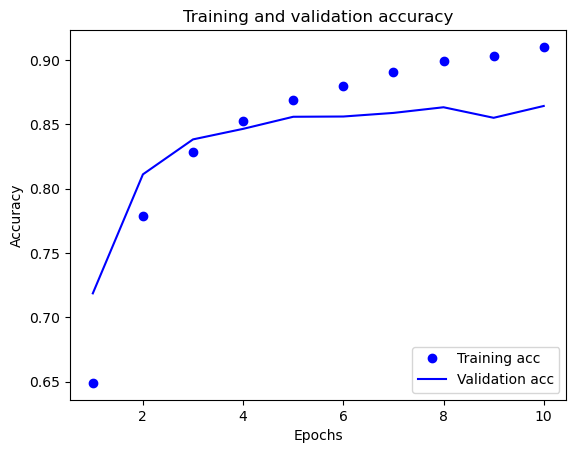

In [36]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the `tf.keras.callbacks.EarlyStopping` callback.

## Export the model

In the code above, you applied the `TextVectorization` layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the `TextVectorization` layer inside your model. To do so, you can create a new model using the weights you just trained.

In [37]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
metrics = export_model.evaluate(raw_test_ds, return_dict=True)
print(metrics)

782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.5042 - loss: 0.5873
{'accuracy': 0.5000399947166443, 'loss': 0.5884262919425964}


 13/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5352 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00  

 26/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5194 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

 39/782 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5152 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

 53/782 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5127 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

 67/782 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5109 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

 81/782 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5077 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

 95/782 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5045 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

109/782 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5022 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

122/782 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5006 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

135/782 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4994 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

148/782 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4986 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

162/782 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4980 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

176/782 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4976 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

190/782 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4973 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

203/782 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4974 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

217/782 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4974 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

231/782 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4974 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

245/782 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4975 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

258/782 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4976 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

272/782 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4977 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

285/782 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4978 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

299/782 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4978 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

313/782 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4979 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

327/782 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4980 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

341/782 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4980 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

355/782 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4980 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

369/782 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4980 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

384/782 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4981 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

399/782 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4981 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

413/782 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4982 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

427/782 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4983 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

441/782 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4984 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

455/782 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4985 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

469/782 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4985 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

483/782 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4986 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

497/782 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4988 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

511/782 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4989 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

525/782 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4990 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

539/782 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4991 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

553/782 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4992 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

567/782 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4992 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

581/782 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4993 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

595/782 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4994 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

609/782 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4995 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

623/782 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4995 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

637/782 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4996 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

651/782 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4997 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

665/782 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4997 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

679/782 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4997 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

693/782 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4997 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

707/782 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4997 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

721/782 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4997 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

735/782 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4997 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

749/782 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4997 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

763/782 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4997 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

778/782 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4997 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4997 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00


{'accuracy': 0.5000399947166443, 'binary_accuracy': 0.0, 'loss': 0.0}


### Inference on new data

To get predictions for new examples, you can simply call `model.predict()`.

In [38]:
examples = tf.constant([
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
])

export_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


array([[0.5868523 ],
       [0.55082107],
       [0.53713566]], dtype=float32)

array([[0.57763124],
       [0.5442707 ],
       [0.53183067]], dtype=float32)

Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew).

There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.

Visit this [tutorial](https://www.tensorflow.org/tutorials/keras/save_and_load) to learn more about saving models.

## Exercise: multi-class classification on Stack Overflow questions

This tutorial showed how to train a binary classifier from scratch on the IMDB dataset. As an exercise, you can modify this notebook to train a multi-class classifier to predict the tag of a programming question on [Stack Overflow](http://stackoverflow.com/).

A [dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) has been prepared for you to use containing the body of several thousand programming questions (for example, "How can I sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java). Your task is to take a question as input, and predict the appropriate tag, in this case, Python.

The dataset you will work with contains several thousand questions extracted from the much larger public Stack Overflow dataset on [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow), which contains more than 17 million posts.

After downloading the dataset, you will find it has a similar directory structure to the IMDB dataset you worked with previously:

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

Note: To increase the difficulty of the classification problem, occurrences of the words Python, CSharp, JavaScript, or Java in the programming questions have been replaced with the word *blank* (as many questions contain the language they're about).

To complete this exercise, you should modify this notebook to work with the Stack Overflow dataset by making the following modifications:

1. At the top of your notebook, update the code that downloads the IMDB dataset with code to download the [Stack Overflow dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) that has already been prepared. As the Stack Overflow dataset has a similar directory structure, you will not need to make many modifications.

1. Modify the last layer of your model to `Dense(4)`, as there are now four output classes.

1. When compiling the model, change the loss to `tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)`. This is the correct loss function to use for a multi-class classification problem, when the labels for each class are integers (in this case, they can be 0, *1*, *2*, or *3*). In addition, change the metrics to `metrics=['accuracy']`, since this is a multi-class classification problem (`tf.metrics.BinaryAccuracy` is only used for binary classifiers).

1. When plotting accuracy over time, change `binary_accuracy` and `val_binary_accuracy` to `accuracy` and `val_accuracy`, respectively.

1. Once these changes are complete, you will be able to train a multi-class classifier.

## Learning more

This tutorial introduced text classification from scratch. To learn more about the text classification workflow in general, check out the [Text classification guide](https://developers.google.com/machine-learning/guides/text-classification/) from Google Developers.
